Цель данного проекта - построить модель, способную предсказать итог футбольного матча из Европейской Лиги, основываясь на определённых характеристиках (игроков, команд и так далее). Для этой цели будет использован набор данных, взятый с сайта kaggle.

In [401]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

Инициализируем базу данных.

In [402]:
conn = sqlite3.connect('database.sqlite')  # https://disk.yandex.ru/d/SzXXSHnMUBK2DQ
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables:
    print(table[0])

sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


Начнём анализ с таблицы match, в которой расположена информация по около двадцати шести тысячам матчей на протяжении 7 лет. Каждый матч обладает более чем сотней характеристик. Давайте разбираться и корректировать таблицу.

In [403]:
match = pd.read_sql('SELECT * FROM Match', conn)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [404]:
match.shape

(25979, 115)

In [405]:
for col in match:
    print(col, match[f'{col}'].dtype)

id int64
country_id int64
league_id int64
season object
stage int64
date object
match_api_id int64
home_team_api_id int64
away_team_api_id int64
home_team_goal int64
away_team_goal int64
home_player_X1 float64
home_player_X2 float64
home_player_X3 float64
home_player_X4 float64
home_player_X5 float64
home_player_X6 float64
home_player_X7 float64
home_player_X8 float64
home_player_X9 float64
home_player_X10 float64
home_player_X11 float64
away_player_X1 float64
away_player_X2 float64
away_player_X3 float64
away_player_X4 float64
away_player_X5 float64
away_player_X6 float64
away_player_X7 float64
away_player_X8 float64
away_player_X9 float64
away_player_X10 float64
away_player_X11 float64
home_player_Y1 float64
home_player_Y2 float64
home_player_Y3 float64
home_player_Y4 float64
home_player_Y5 float64
home_player_Y6 float64
home_player_Y7 float64
home_player_Y8 float64
home_player_Y9 float64
home_player_Y10 float64
home_player_Y11 float64
away_player_Y1 float64
away_player_Y2 float64
aw

Первые несколько колонок отвечают за самую базовую информацию о матче (его id в системе, сезоне проведения, даты, поля). Естественно, здесь ничего трогать не нужно: это необходимая информация.

Далее следуют количество забитых голов каждой из комманд. Эти переменные (а точнее их разница) и будут спрогнозированы нашей моделью. Оставим их в обучающей выборке, но убёрем в тестовой. 

После этого идут данные о стартовом составе обеих команд: стартовая позиция игроков на поле в координатах (X, Y) и, естественно, их id для связи с другими таблицами. Это мы пока тоже оставим в модели. 

Следующими столбцами идёт информация о ходе матча (количестве фолов, угловых и так далее). Так как эти переменные известны уже после матча и не являются целевыми, то их мы уберём, ведь наша цель - предсказать исход матча, а не угадать его постфактум.

Наконец, в самом конце располагается целое море стобцов с коэффициентами разных букмекеров на тот или иной исход матча (первые две буквы переменной обозначают букмекера, а последняя - на какой исход рассчитывается этот коэффициент: H - победа home team, A - победа away team, D - draw). Все эти переменные мы так же решили убрать, так как не видим в них особой ценности, но памяти они занимают невероятно много.

In [406]:
columns_bookers = ['B365H',
                   'B365D',
                   'B365A',
                   'BWH',
                   'BWD',
                   'BWA',
                   'IWH',
                   'IWD',
                   'IWA',
                   'LBH',
                   'LBD',
                   'LBA',
                   'PSH',
                   'PSD',
                   'PSD',
                   'PSA',
                   'WHH',
                   'WHD',
                   'WHA',
                   'SJH',
                   'SJD',
                   'SJA',
                   'VCH',
                   'VCD',
                   'VCA',
                   'GBH',
                   'GBD',
                   'GBA',
                   'BSH',
                   'BSD',
                   'BSA']
match.drop(columns=columns_bookers, inplace=True)

In [407]:
columns_with_logs = ['goal',
                     'shoton',
                     'shotoff',
                     'foulcommit',
                     'card',
                     'cross',
                     'corner',
                     'possession']
match.drop(columns=columns_with_logs, inplace=True)

А ещё заменим тип данных в столбце date на правильный.

In [408]:
match['date'] = pd.to_datetime(match['date'])

In [409]:
match.shape

(25979, 77)

Уже появилось больше воздуха, но это только начало. Из оставшихся переменных наиболее неинтуитивными являются переменные, отвечающие за позиции игроков на поле. Давайте попробуем лучше их понять, нарисовав графики облак распределения.

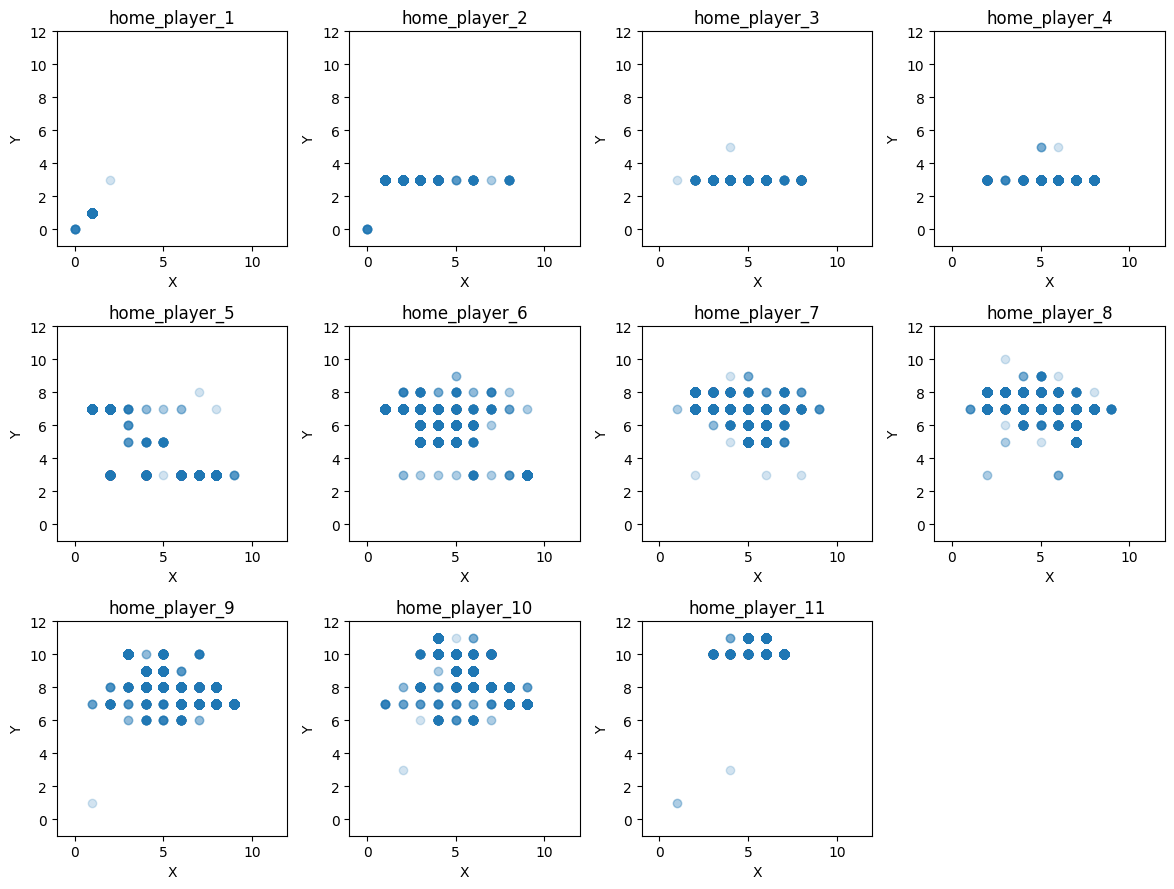

In [410]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'home_player_X{i}'], match[f'home_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'home_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
axs[11].axis('off')
plt.show()

Теперь наглядно видно, какую позицию на поле занимает игрок. Очевидно, что чем больше Y, тем "выше" располагается игрок, то есть ближе к центру поля. Тогда вратарь будет иметь минимальное значение среди возможных: 0. Что интересно, все игроки с координатой Y = 0 имеют координату X = 0, то есть X = Y. Это важно для следующего рассуждения: помимо игроков с координатами (0; 0) встречается также большое число игроков с координатами (1; 1), причем это единственные игроки на X = 1. Логично будет предположить, что вратарям дают координаты X = Y, где Y минимальный из допустимых, просто в каких-то сезонах (или лигах) минимальный Y - это 0, а в других - это 1.

При этом, что интересно, подобная "неразбериха" с вратарями присутствует только у home_team, у away_team явно видно, что все вратари имеют координаты.

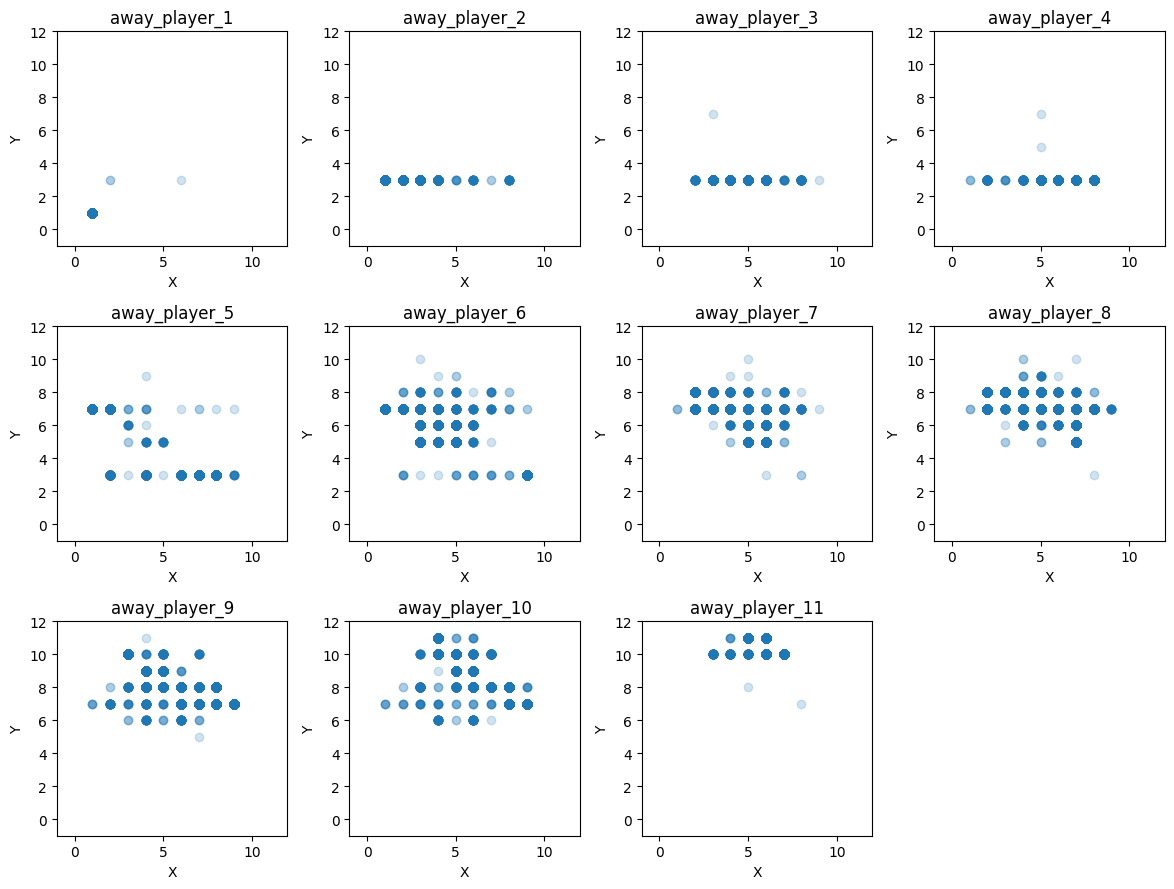

In [411]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'away_player_X{i}'], match[f'away_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'away_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
axs[11].axis('off')
plt.show()

Однако тут сразу очевидна другая проблема: все вратари включены в away_player_1, но при этом не все away_player_1 - вратари. Получается, что в некоторых матчах гостевая команда играла без вратаря, что абсурдно.

In [412]:
for i in range(1, 12):
    print(len(match[(match[f'home_player_X{i}'] <= 1) & (match[f'home_player_Y{i}'] <= 1)]))

24157
11
0
0
0
0
0
0
1
0
2


In [413]:
print(len(match[match[f'home_player_X{1}'] > 1]))

1


Более того, вернувшись к home_player, можно обнаружить, что всего вратарей, не включенных в home_player_1 - 14, а вот не-вратарей, включенных в home_player_1, всего 1, то есть домашняя команда в некоторых мачтах, наоборот, как будто бы играла с более чем одним вратарём на поле. Давайте посмотрим на пропуски, возможно, что именно в них и кроется проблема.

In [414]:
match.isna().sum()

id                   0
country_id           0
league_id            0
season               0
stage                0
                  ... 
away_player_7     1235
away_player_8     1341
away_player_9     1328
away_player_10    1441
away_player_11    1554
Length: 77, dtype: int64

Действительно, видно, что существует большое число пропусков, причем исключительно в столбцах, отвечающих за расположение игроков. Давайте удалим их и посмотрим, что у нас останется.

In [415]:
match = match.dropna()
match.isna().sum()

id                0
country_id        0
league_id         0
season            0
stage             0
                 ..
away_player_7     0
away_player_8     0
away_player_9     0
away_player_10    0
away_player_11    0
Length: 77, dtype: int64

In [416]:
match.shape

(21361, 77)

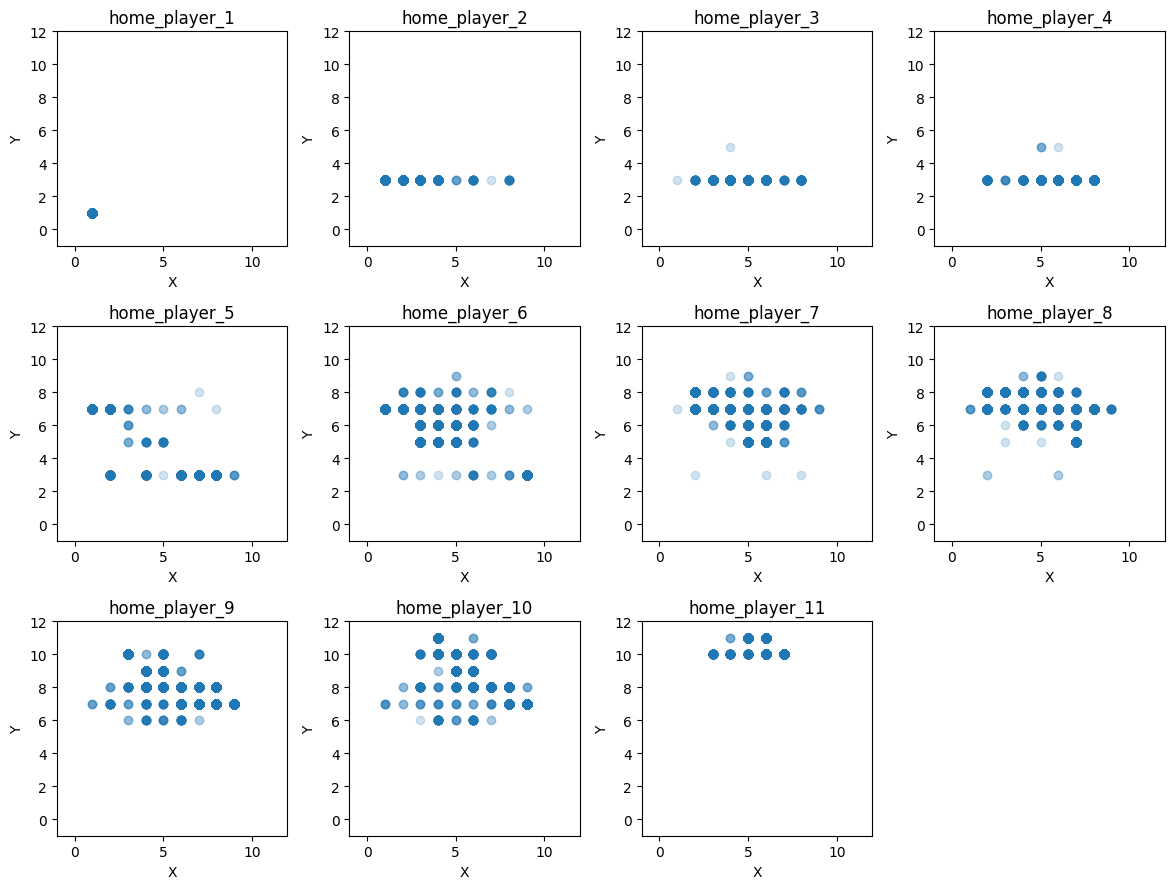

In [417]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'home_player_X{i}'], match[f'home_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'home_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
axs[11].axis('off')
plt.show()

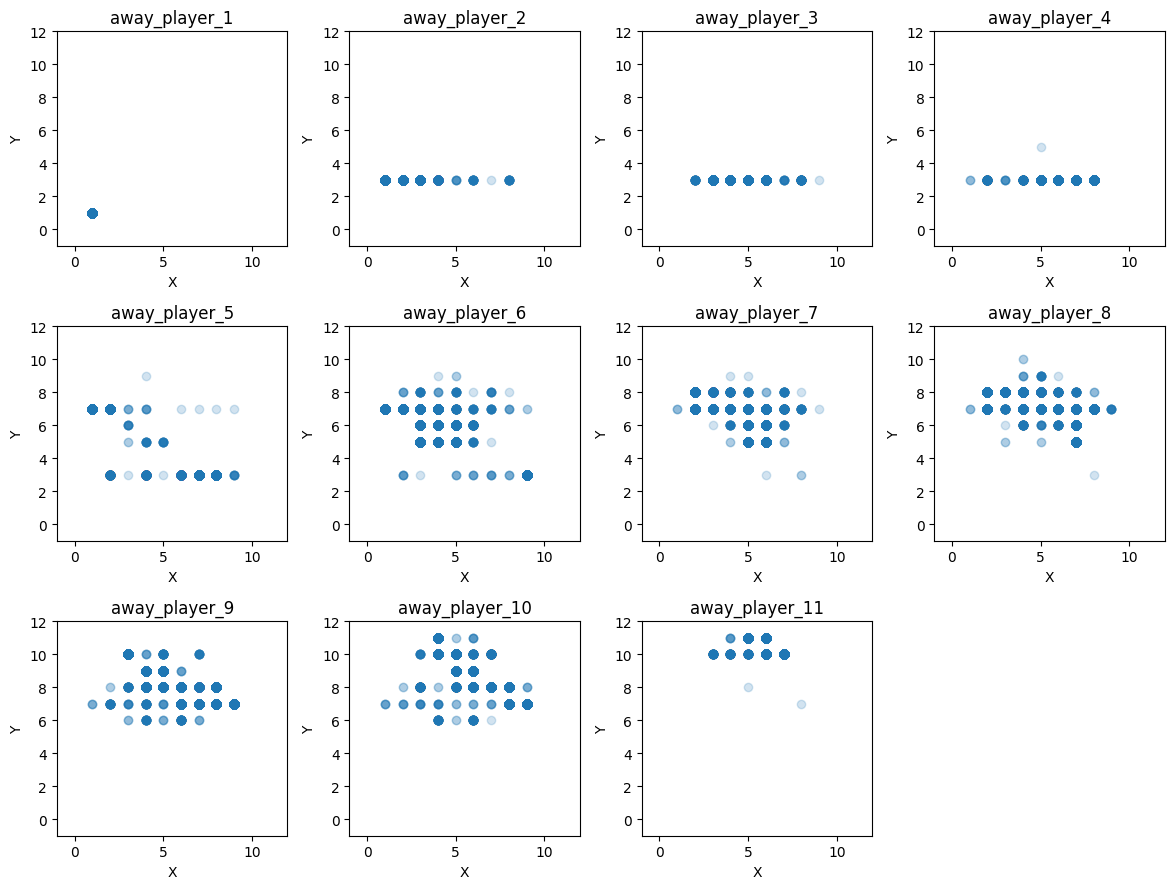

In [418]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'away_player_X{i}'], match[f'away_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'away_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
axs[11].axis('off')
plt.show()

Теперь всё отлично: все вратари находятся исключительно в столбцах home_player_1 и away_player_1. Что интересно, в home_player пропали вратари с координатами (0; 0). 

На основе этих выводов сделаем отдельный массив с вратарями и отдельный массив с полевыми игроками

In [419]:
goalkeepers = []
home_goalkeepers = match['home_player_1'].values
away_goalkeepers = match['away_player_1'].values
goalkeepers = np.unique(np.append(np.append(home_goalkeepers, away_goalkeepers), goalkeepers))

In [420]:
fielders = []
for i in range(2, 12):
    home_fielders = match[f'home_player_{i}'].values
    away_fielders = match[f'away_player_{i}'].values
    fielders = np.unique(np.append(np.append(home_fielders, away_fielders), fielders))

Давайте для интереса попробуем разбить полевых игроков на допольнительные подкатегории: защитники, полузащитники и нападающие. Для примера будем считать, что защитники располагаются на Y = 3, так как именно на этом значении очень много игроков; полузащитники располагаются по Y на (3; 8], а нападающие на Y > 8. Посмотрим, будут ли пересечния у этих групп. Если их не будет, то можно будет задуматься о добавлении этих подкатегорий, вместо просто вратарей и полевых.

In [421]:
defenders = []
for i in range(2, 12):
    home_defenders = match[match[f'home_player_Y{i}'] == 3][f'home_player_{i}'].values
    away_defenders = match[match[f'away_player_Y{i}'] == 3][f'away_player_{i}'].values
    defenders = np.unique(np.append(np.append(home_defenders, away_defenders), defenders))

In [422]:
midfielders = []
for i in range(2, 12):
    home_midfielders = match[(match[f'home_player_Y{i}'] > 3) & (match[f'home_player_Y{i}'] <= 8)][f'home_player_{i}'].values
    away_midfielders = match[(match[f'away_player_Y{i}'] > 3) & (match[f'away_player_Y{i}'] <= 8)][f'away_player_{i}'].values
    midfielders = np.unique(np.append(np.append(home_midfielders, away_midfielders), midfielders))

In [423]:
attackers = []
for i in range(2, 12):
    home_attackers = match[match[f'home_player_Y{i}'] > 8][f'home_player_{i}'].values
    away_attackers = match[match[f'away_player_Y{i}'] > 8][f'away_player_{i}'].values
    attackers = np.unique(np.append(np.append(home_attackers, away_attackers), attackers))

In [424]:
len(np.intersect1d(defenders, midfielders))

2472

In [425]:
len(np.intersect1d(midfielders, attackers))

3389

In [426]:
len(np.intersect1d(defenders, attackers))

843

Как видим, пересечений в этих категориях довольно много (даже между защитниками и нападающими), а изменении координат ничего по факту не меняет. Придётся остановиться на более обширной категории fielders. Опеределившись с этим, можно удалить переменные координат, так как, помимо определения вратарей и полевых, что мы уже сделали, никакой принципиальной роли они уже не играют, а места занимают много.

In [427]:
for i in range(1, 12):
    match.drop(columns=[f'home_player_X{i}', f'home_player_Y{i}'], inplace=True)
    match.drop(columns=[f'away_player_X{i}', f'away_player_Y{i}'], inplace=True)

In [428]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
145,146,1,1,2008/2009,24,2009-02-27,493017,8203,9987,2,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
153,154,1,1,2008/2009,25,2009-03-08,493025,9984,8342,1,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
155,156,1,1,2008/2009,25,2009-03-07,493027,8635,10000,2,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
162,163,1,1,2008/2009,26,2009-03-13,493034,8203,8635,2,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
168,169,1,1,2008/2009,26,2009-03-14,493040,10000,9999,0,...,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


In [429]:
match.shape

(21361, 33)

Посмотрим на таблицу под названием league.

In [430]:
league = pd.read_sql('SELECT * FROM League', conn)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


Она содержит только информацию о названиях лиг.

Тогда заменим столбец league_id из таблицы match соответствующим названием.

In [431]:
league.rename(columns={'id': 'league_id', 'name': 'league_name'}, inplace=True)
match = pd.merge(match, league, on='league_id', how='right')

match.drop(['league_id', 'country_id_y', 'country_id_x'], axis=1, inplace=True)

In [432]:
match.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,league_name
0,146,2008/2009,24,2009-02-27,493017,8203,9987,2,1,38327.0,...,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0,Belgium Jupiler League
1,154,2008/2009,25,2009-03-08,493025,9984,8342,1,3,36835.0,...,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0,Belgium Jupiler League
2,156,2008/2009,25,2009-03-07,493027,8635,10000,2,0,34480.0,...,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0,Belgium Jupiler League
3,163,2008/2009,26,2009-03-13,493034,8203,8635,2,1,38327.0,...,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0,Belgium Jupiler League
4,169,2008/2009,26,2009-03-14,493040,10000,9999,0,0,37900.0,...,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0,Belgium Jupiler League


Теперь посмотрим на таблицу team. 

In [433]:
team = pd.read_sql('SELECT * FROM Team', conn)
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


В данной таблице, аналогично предыдущей, располагается только информация о названии команд. Внесём эту информацию в таблицу match.

In [434]:
team.rename(columns={'team_long_name': 'team_name'}, inplace=True)
team.drop(['team_fifa_api_id', 'id', 'team_short_name'], axis=1, inplace=True)

In [435]:
match = pd.merge(match, team, left_on='home_team_api_id', right_on='team_api_id', how='left')

In [436]:
match = pd.merge(match, team, left_on='away_team_api_id', right_on='team_api_id', how='left')

In [437]:
match.drop(['away_team_api_id', 'id', 'home_team_api_id', 'team_api_id_x', 'team_api_id_y'], axis=1, inplace=True)
match.rename(columns={'team_name_x': 'home_team_name', 'team_name_y': 'away_team_name', }, inplace=True)

In [438]:
match.insert(0, 'home_team_name', match.pop('home_team_name'))
match.insert(0, 'away_team_name', match.pop('away_team_name'))
match.insert(0, 'league_name', match.pop('league_name'))

In [439]:
match.head()

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,Belgium Jupiler League,KRC Genk,KV Mechelen,2008/2009,24,2009-02-27,493017,2,1,38327.0,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
1,Belgium Jupiler League,Club Brugge KV,KSV Cercle Brugge,2008/2009,25,2009-03-08,493025,1,3,36835.0,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
2,Belgium Jupiler League,SV Zulte-Waregem,RSC Anderlecht,2008/2009,25,2009-03-07,493027,2,0,34480.0,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
3,Belgium Jupiler League,RSC Anderlecht,KV Mechelen,2008/2009,26,2009-03-13,493034,2,1,38327.0,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
4,Belgium Jupiler League,KSV Roeselare,SV Zulte-Waregem,2008/2009,26,2009-03-14,493040,0,0,37900.0,...,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


Всё, теперь мы окончательно оформили таблицу match: никаких id (помимо собственно матчей) здесь не осталось. 

Перейдём к следующей масштабной таблице: таблице характеристик команд.

In [440]:
team_attributes = pd.read_sql('SELECT * FROM Team_Attributes', conn)
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [441]:
team_attributes['date'] = pd.to_datetime(team_attributes['date'])

Опять же заменим id команд на их названия из таблицы team.

In [442]:
team_attributes = pd.merge(team_attributes, team, left_on='team_api_id', right_on='team_api_id', how='left')

In [443]:
team_attributes.drop(['team_fifa_api_id', 'id', 'team_api_id'], axis=1, inplace=True)

team_attributes.insert(0, 'team_name', team_attributes.pop('team_name'))

In [444]:
team_attributes

,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,FC Aarau,2010-02-22,60,Balanced,NaN,Little,50,Mixed,Organised,60,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,FC Aarau,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,FC Aarau,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,Aberdeen,2010-02-22,70,Fast,NaN,Little,70,Long,Organised,70,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,Aberdeen,2011-02-22,47,Balanced,NaN,Little,52,Mixed,Organised,53,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,SV Zulte-Waregem,2011-02-22,52,Balanced,NaN,Little,52,Mixed,Organised,52,...,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover
1454,SV Zulte-Waregem,2012-02-22,54,Balanced,NaN,Little,51,Mixed,Organised,47,...,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover
1455,SV Zulte-Waregem,2013-09-20,54,Balanced,NaN,Little,51,Mixed,Organised,47,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
1456,SV Zulte-Waregem,2014-09-19,54,Balanced,42.0,Normal,51,Mixed,Organised,47,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover


In [445]:
for col in team_attributes:
    print(col, '---', team_attributes[f'{col}'].dtype)

team_name --- object
date --- datetime64[ns]
buildUpPlaySpeed --- int64
buildUpPlaySpeedClass --- object
buildUpPlayDribbling --- float64
buildUpPlayDribblingClass --- object
buildUpPlayPassing --- int64
buildUpPlayPassingClass --- object
buildUpPlayPositioningClass --- object
chanceCreationPassing --- int64
chanceCreationPassingClass --- object
chanceCreationCrossing --- int64
chanceCreationCrossingClass --- object
chanceCreationShooting --- int64
chanceCreationShootingClass --- object
chanceCreationPositioningClass --- object
defencePressure --- int64
defencePressureClass --- object
defenceAggression --- int64
defenceAggressionClass --- object
defenceTeamWidth --- int64
defenceTeamWidthClass --- object
defenceDefenderLineClass --- object


Давайте я вам расскажу, за что отвечает каждая колонка в этой таблице. Сразу стоит напомнить, что рейтинги команд периодически обновляются, поэтому нет ничего удвительного в том, что одна и та же команда встречается несколько раз. Если вкратце, характеристики, начинающиеся с buildUp, отвечают за сыгранность команды. chanceCreation в первую очередь отвечает за создание атакающих моментов в игре, благодаря повышению вероятности точных передач, граммотного позиционирования и так далее. Наконец, как не сложно догадаться, параметры, начинающиеся с defence, характеризуют эффективность и тактику обороны команды, например, степень прессинга во время обороны или глубину оборонительной линии.

Значения в столбцах, оканчивающихся на Class, напрямую зависят от числа в предшествующем им столбце с тем же названием, но без приписки Class. Иными словами, класс команды по той или иной характеристике зависит от того, в какой интервал попадает значение этой характеристики. Соответственно, оставлять оба столбца (с Class и без) не имеет никакого смысла, ведь они напрямую коррелируют друг с другом и вообще отвечают за один и тот же параметр команды. На данный момент мы пришли к выводу, что лучше удалить все столбцы с Class, оставив стобцы с числами, для более точного обучения модели, однако мы не исключаем, что модель может переобучиться, и тогда мы вернемся именно к Class-столбцам.

In [446]:
team_attributes['buildUpPlaySpeedClass'].value_counts()

buildUpPlaySpeedClass
Balanced    1184
Fast         172
Slow         102
Name: count, dtype: int64

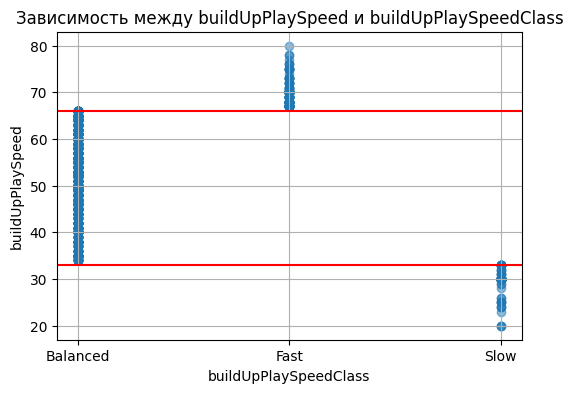

In [447]:
plt.figure(figsize=(6, 4))
plt.scatter(team_attributes['buildUpPlaySpeedClass'], team_attributes['buildUpPlaySpeed'],
            alpha=0.5)
plt.axhline(y=team_attributes[team_attributes['buildUpPlaySpeedClass'] == 'Balanced']['buildUpPlaySpeed'].max()
            , color='red')
plt.axhline(y=team_attributes[team_attributes['buildUpPlaySpeedClass'] == 'Slow']['buildUpPlaySpeed'].max()
            , color='red')
plt.title('Зависимость между buildUpPlaySpeed и buildUpPlaySpeedClass')
plt.xlabel('buildUpPlaySpeedClass')
plt.ylabel('buildUpPlaySpeed')
plt.grid(True)
plt.show()

Удалим все переменные, которые кончаются на Class, а в остальном повторяют название вышестоящей переменной. Это важное уточнение, так как переменные buildUpPlayPositioningClass, chanceCreationPositioningClass, defenceDefenderLineClass "берут" свои значения не из соответствующей им целочисленной переменной, а являются сугубо категориальными. Начнём с удаления buildUp столбцов

In [448]:
team_attributes.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass'], axis=1,
                     inplace=True)

Как было сказано выше, cледующий признак, buildUpPlayPositioningClass, встречается только в виде категориальной переменной, а потому убрать его мы себе позволить не можем.

In [449]:
team_attributes['buildUpPlayPositioningClass'].value_counts()

buildUpPlayPositioningClass
Organised    1386
Free Form      72
Name: count, dtype: int64

Более того, он принимает всего два значения: Organised и Free Form. С помощью OHE-Кодинга оставим только признак buildUpPlayPositioning_Organised.

In [450]:
team_attributes_encoded = pd.get_dummies(team_attributes['buildUpPlayPositioningClass'],
                                         prefix='buildUpPlayPositioning')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['buildUpPlayPositioningClass', 'buildUpPlayPositioning_Free Form'], axis=1, inplace=True)

Настал черёд столбцов chanceCreation.

In [451]:
team_attributes.drop(['chanceCreationPassingClass', 'chanceCreationCrossingClass', 'chanceCreationShootingClass'],
                     axis=1, inplace=True)

Опять подкорректируем сугубо категориальную переменную chanceCreationPositioningClass с помощью OHE-кодинга.

In [452]:
team_attributes['chanceCreationPositioningClass'].value_counts()

chanceCreationPositioningClass
Organised    1309
Free Form     149
Name: count, dtype: int64

In [453]:
team_attributes_encoded = pd.get_dummies(team_attributes['chanceCreationPositioningClass'],
                                         prefix='chanceCreationPositioning')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['chanceCreationPositioningClass', 'chanceCreationPositioning_Free Form'], axis=1, inplace=True)

Переходим к defence...

In [454]:
team_attributes.drop(['defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass'], axis=1, inplace=True)

И исправим последнюю переменную с помощью OHE-кодинга.

In [455]:
team_attributes['defenceDefenderLineClass'].value_counts()

defenceDefenderLineClass
Cover           1362
Offside Trap      96
Name: count, dtype: int64

In [456]:
team_attributes_encoded = pd.get_dummies(team_attributes['defenceDefenderLineClass'],
                                         prefix='defenceDefenderLine')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['defenceDefenderLineClass', 'defenceDefenderLine_Offside Trap'], axis=1, inplace=True)

Теперь проверим, есть ли в данных какие-то пропуски.

In [457]:
team_attributes.isna().sum()

team_name                                0
date                                     0
buildUpPlaySpeed                         0
buildUpPlayDribbling                   969
buildUpPlayPassing                       0
chanceCreationPassing                    0
chanceCreationCrossing                   0
chanceCreationShooting                   0
defencePressure                          0
defenceAggression                        0
defenceTeamWidth                         0
buildUpPlayPositioning_Organised         0
chanceCreationPositioning_Organised      0
defenceDefenderLine_Cover                0
dtype: int64

In [458]:
team_attributes.shape

(1458, 14)

Действительно, пропуски были обнаружены, и причем очень много: 969 пропусков из 1458 значений. Хорошо, что эти пропуски встречаются лишь по одной переменной, buildUpPlayDribbling. Скорее всего это связано с тем, что её добавили в одной из последних версий фифы. Мы думаем, что можно спокойно удалить этот параметр, не навредив нашей модели.

In [459]:
team_attributes.drop('buildUpPlayDribbling', axis=1, inplace=True)

In [460]:
team_attributes.isna().sum()

team_name                              0
date                                   0
buildUpPlaySpeed                       0
buildUpPlayPassing                     0
chanceCreationPassing                  0
chanceCreationCrossing                 0
chanceCreationShooting                 0
defencePressure                        0
defenceAggression                      0
defenceTeamWidth                       0
buildUpPlayPositioning_Organised       0
chanceCreationPositioning_Organised    0
defenceDefenderLine_Cover              0
dtype: int64

In [461]:
team_attributes

,team_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioning_Organised,chanceCreationPositioning_Organised,defenceDefenderLine_Cover
0,FC Aarau,2010-02-22,60,50,60,65,55,50,55,45,True,True,True
1,FC Aarau,2014-09-19,52,56,54,63,64,47,44,54,True,True,True
2,FC Aarau,2015-09-10,47,54,54,63,64,47,44,54,True,True,True
3,Aberdeen,2010-02-22,70,70,70,70,70,60,70,70,True,True,True
4,Aberdeen,2011-02-22,47,52,53,48,52,47,47,52,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,SV Zulte-Waregem,2011-02-22,52,52,52,48,53,46,48,53,True,True,True
1454,SV Zulte-Waregem,2012-02-22,54,51,47,52,50,44,55,53,True,True,True
1455,SV Zulte-Waregem,2013-09-20,54,51,47,52,32,44,58,37,True,True,True
1456,SV Zulte-Waregem,2014-09-19,54,51,47,52,32,44,58,37,True,True,True


Перейдём к последней и самой важной составляющей любого футбольного матча, к игрокам, характеристики которых находятся в таблице player_attributes.

In [462]:
player_attributes = pd.read_sql('SELECT * FROM Player_Attributes', conn)
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


Сразу заменим player_api_id на имена, которые есть в таблице player, а также добавим показатели веса, роста и даты рождения.

In [463]:
player = pd.read_sql('SELECT * FROM Player', conn)
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [464]:
player.drop(['player_fifa_api_id', 'id'], axis=1, inplace=True)
player_attributes.drop(['player_fifa_api_id', 'id'], axis=1, inplace=True)

In [465]:
player_attributes = pd.merge(player_attributes, player, left_on='player_api_id', right_on='player_api_id', how='left')

In [466]:
player_attributes['birthday'] = pd.to_datetime(player_attributes['birthday'])
player_attributes['date'] = pd.to_datetime(player_attributes['date'])
player_attributes['age'] = (player_attributes['date'] - player_attributes['birthday']).dt.days // 365
player_attributes.drop('birthday', axis=1, inplace=True)

In [467]:
player_attributes.insert(0, 'age', player_attributes.pop('age'))
player_attributes.insert(0, 'weight', player_attributes.pop('weight'))
player_attributes.insert(0, 'height', player_attributes.pop('height'))
player_attributes.insert(0, 'player_name', player_attributes.pop('player_name'))

In [468]:
player_attributes.head()

,player_name,height,weight,age,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,Aaron Appindangoye,182.88,187,23,505942,2016-02-18,67.0,71.0,right,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,Aaron Appindangoye,182.88,187,23,505942,2015-11-19,67.0,71.0,right,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,Aaron Appindangoye,182.88,187,23,505942,2015-09-21,62.0,66.0,right,medium,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,Aaron Appindangoye,182.88,187,23,505942,2015-03-20,61.0,65.0,right,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,Aaron Appindangoye,182.88,187,14,505942,2007-02-22,61.0,65.0,right,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [469]:
for col in player_attributes:
    print(col, player_attributes[f'{col}'].dtype)

player_name object
height float64
weight int64
age int64
player_api_id int64
date datetime64[ns]
overall_rating float64
potential float64
preferred_foot object
attacking_work_rate object
defensive_work_rate object
crossing float64
finishing float64
heading_accuracy float64
short_passing float64
volleys float64
dribbling float64
curve float64
free_kick_accuracy float64
long_passing float64
ball_control float64
acceleration float64
sprint_speed float64
agility float64
reactions float64
balance float64
shot_power float64
jumping float64
stamina float64
strength float64
long_shots float64
aggression float64
interceptions float64
positioning float64
vision float64
penalties float64
marking float64
standing_tackle float64
sliding_tackle float64
gk_diving float64
gk_handling float64
gk_kicking float64
gk_positioning float64
gk_reflexes float64


Вряд ли есть необходимость в объяснении каждой из переменной этой таблицы, так как они просто отображают различные игровые параметры игрока, понятные из названия. Стоит отметить только, что переменные, начинающиеся с gk относятся к вратарским навыкам.

Посмотрим, играли ли в матчах футболисты, не записанные в таблице player_attributes.

In [470]:
import numpy as np

players_in_realdata = set()
for i in range(1, 12):
    players_in_realdata.update(match[f'home_player_{i}'])
    players_in_realdata.update(match[f'away_player_{i}'])

players_in_realdata = np.array(list(players_in_realdata))
player_without_attributes = np.setdiff1d(players_in_realdata, player_attributes['player_api_id'])

player_without_attributes

array([], dtype=float64)

Нет, таких футболистов нет, все отлично.

Узнаем, есть ли в таблице пропуски.

In [471]:
player_attributes.isna().sum()

player_name               0
height                    0
weight                    0
age                       0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties           

Пропусков действительно довольно много. Попробуем ограничить временные рамки более поздними годами, когда, предположительно, данные стали более полными. Давайте возьмём промежуток, начиная с сезона 2008/2009.

In [472]:
player_attributes.loc[player_attributes['date'] > '2008-07-01'].isna().sum()

player_name               0
height                    0
weight                    0
age                       0
player_api_id             0
date                      0
overall_rating          100
potential               100
preferred_foot          100
attacking_work_rate    1596
defensive_work_rate     100
crossing                100
finishing               100
heading_accuracy        100
short_passing           100
volleys                1159
dribbling               100
curve                  1159
free_kick_accuracy      100
long_passing            100
ball_control            100
acceleration            100
sprint_speed            100
agility                1159
reactions               100
balance                1159
shot_power              100
jumping                1159
stamina                 100
strength                100
long_shots              100
aggression              100
interceptions           100
positioning             100
vision                 1159
penalties           

Давайте возьмём еще попозже, начиная с сезона 2011/2012.

In [473]:
player_attributes.loc[player_attributes['date'] > '2011-07-01'].isna().sum()

player_name             0
height                  0
weight                  0
age                     0
player_api_id           0
date                    0
overall_rating         86
potential              86
preferred_foot         86
attacking_work_rate    86
defensive_work_rate    86
crossing               86
finishing              86
heading_accuracy       86
short_passing          86
volleys                86
dribbling              86
curve                  86
free_kick_accuracy     86
long_passing           86
ball_control           86
acceleration           86
sprint_speed           86
agility                86
reactions              86
balance                86
shot_power             86
jumping                86
stamina                86
strength               86
long_shots             86
aggression             86
interceptions          86
positioning            86
vision                 86
penalties              86
marking                86
standing_tackle        86
sliding_tack

Как мы видим, во всех категориях теперь одинаковое число пропусков. Скорее всего это одни и те же люди. Проверим.

In [474]:
player_attributes[player_attributes['date'] > '2011-07-01'].isnull().any(axis=1).sum()

86

In [475]:
post_2011 = player_attributes[player_attributes['date'] > '2011-07-01']

In [476]:
post_2011_players_without_attributes = post_2011[post_2011.isnull().any(axis=1)]['player_api_id']
post_2011_players_without_attributes

7452      163838
7454      163838
7455      163838
7458      163838
35762     157249
           ...  
159529     42116
159530     42116
167344     32705
171605     30876
175375    451941
Name: player_api_id, Length: 86, dtype: int64

In [477]:
np.setdiff1d(post_2011_players_without_attributes, players_in_realdata)

array([], dtype=int64)

Мало того, что это одни и те же игроки, так эти футболисты еще и не играли ни в одном из матчей. 

Пока не будем ничего убирать, так как в конце концов мы все равно сведём всё к таблице match, в которой не будут отображаться неиграющие футболисты, а с временными рамками мы определимся попозже.

Приступим к корректировке имеющихся переменных.

Начнём с того, что удалим переменную потенциал, которая непонятно как может влиять на исход матча.

In [478]:
player_attributes.drop('potential', axis=1, inplace=True)

Сделаем OHE-кодирование для переменной, отвечающей за рабочую ногу, так как она принимает всего два значения.

In [479]:
player_attributes['preferred_foot'].value_counts()

preferred_foot
right    138409
left      44733
Name: count, dtype: int64

In [480]:
player_attributes_encoded = pd.get_dummies(player_attributes['preferred_foot'],
                                           prefix='preferred_foot')

player_attributes = pd.concat([player_attributes, player_attributes_encoded], axis=1)

player_attributes.drop(['preferred_foot', 'preferred_foot_left'], axis=1, inplace=True)

Проанализируем переменную attacking_work_rate.

In [481]:
player_attributes['attacking_work_rate'].value_counts()

attacking_work_rate
medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: count, dtype: int64

Так как различных переменных, отвечающих за навыки игрока, слишком много, нами было принято решении сократить их число, преобразовав их в новые переменные, каждая из которых является средневзвешенной нескольких идейно близких переменных с коэффициентами, взятыми из самой FIFA.

In [482]:
player_attributes['pace'] = 0.55 * player_attributes['sprint_speed'] + 0.45 * player_attributes['acceleration']
player_attributes['shooting'] = 0.45 * player_attributes['finishing'] + 0.2 * player_attributes['long_shots'] + 0.2 * \
                                player_attributes['shot_power'] + 0.05 * player_attributes[
                                    'positioning'] + 0.05 * player_attributes['penalties'] + 0.05 * player_attributes[
                                    'volleys']
player_attributes['passing'] = 0.35 * player_attributes['short_passing'] + 0.2 * player_attributes['vision'] + 0.2 * \
                               player_attributes['crossing'] + 0.15 * player_attributes[
                                   'long_passing'] + 0.05 * player_attributes['curve'] + 0.05 * player_attributes[
                                   'free_kick_accuracy']
player_attributes['dribbling'] = 0.5 * player_attributes['dribbling'] + 0.35 * player_attributes['ball_control'] + 0.1 * \
                                 player_attributes['agility'] + 0.05 * player_attributes['balance']
player_attributes['defending'] = 0.3 * player_attributes['marking'] + 0.3 * player_attributes['standing_tackle'] + 0.2 * \
                                 player_attributes['interceptions'] + 0.1 * player_attributes[
                                     'heading_accuracy'] + 0.1 * player_attributes['sliding_tackle']
player_attributes['physical'] = 0.5 * player_attributes['strength'] + 0.25 * player_attributes['stamina'] + 0.25 * \
                                player_attributes['aggression'] + 0.05 * player_attributes['jumping']

Так как переменные выше в полной мере описывают и атакующие, и защитные навыки игроков, мы решили удалить переменные attacking_work_rate и defensive_work_rate, которые нам кажутся избыточными.

In [483]:
player_attributes.drop('attacking_work_rate', axis=1, inplace=True)

In [484]:
player_attributes.drop('defensive_work_rate', axis=1, inplace=True)

Теперь сделаем отдельные таблицы для полевых игроков и вратарей, чтобы оставить для каждой из категорий только самые релевантные характеристики. В конце концов вряд ли "вратарские рефлексы" нападающего или способность вратаря бить головой сильно повлияют на ход матча, а модель они усложняют.

In [485]:
gk_attributes = player_attributes[player_attributes['player_api_id'].isin(goalkeepers)].copy()

In [486]:
fl_attributes = player_attributes[player_attributes['player_api_id'].isin(fielders)].copy()

In [487]:
fl_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,crossing,finishing,heading_accuracy,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,pace,shooting,passing,defending,physical
0,Aaron Appindangoye,182.88,187,23,505942,2016-02-18,67.0,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,True,62.20,44.65,55.75,68.2,72.15
1,Aaron Appindangoye,182.88,187,23,505942,2015-11-19,67.0,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,True,62.20,44.65,55.75,68.2,72.15
2,Aaron Appindangoye,182.88,187,23,505942,2015-09-21,62.0,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,True,62.20,44.65,55.75,61.5,70.15
3,Aaron Appindangoye,182.88,187,23,505942,2015-03-20,61.0,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,True,62.20,43.65,54.75,59.1,69.90
4,Aaron Appindangoye,182.88,187,14,505942,2007-02-22,61.0,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,True,62.20,43.65,54.75,59.1,69.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,Zvjezdan Misimovic,180.34,176,27,39902,2009-08-30,83.0,84.0,77.0,59.0,...,20.0,84.0,20.0,20.0,True,69.30,78.35,86.35,40.4,68.40
183974,Zvjezdan Misimovic,180.34,176,26,39902,2009-02-22,78.0,74.0,76.0,53.0,...,20.0,73.0,20.0,20.0,True,66.55,74.75,80.75,40.0,67.15
183975,Zvjezdan Misimovic,180.34,176,26,39902,2008-08-30,77.0,74.0,71.0,53.0,...,20.0,73.0,20.0,20.0,True,66.55,72.50,80.75,40.0,68.65
183976,Zvjezdan Misimovic,180.34,176,25,39902,2007-08-30,78.0,74.0,64.0,57.0,...,20.0,73.0,20.0,20.0,True,60.45,68.70,81.40,39.3,64.90


In [488]:
gk_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,crossing,finishing,heading_accuracy,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,pace,shooting,passing,defending,physical
172,Aaron Lennox,190.50,181,23,528212,2016-02-25,48.0,12.0,15.0,16.0,...,41.0,39.0,51.0,53.0,True,21.05,17.80,17.75,15.6,33.65
173,Aaron Lennox,190.50,181,22,528212,2016-01-28,48.0,12.0,15.0,16.0,...,41.0,39.0,51.0,53.0,True,21.05,17.80,17.75,15.6,33.65
174,Aaron Lennox,190.50,181,21,528212,2014-12-27,48.0,12.0,15.0,16.0,...,41.0,39.0,51.0,53.0,True,21.05,17.80,17.75,15.6,33.65
175,Aaron Lennox,190.50,181,21,528212,2014-10-31,48.0,12.0,15.0,16.0,...,41.0,39.0,51.0,53.0,True,21.05,17.80,17.75,15.6,33.65
176,Aaron Lennox,190.50,181,21,528212,2014-10-10,48.0,12.0,15.0,16.0,...,41.0,39.0,51.0,53.0,True,21.05,17.80,17.75,15.6,33.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183534,Zeljko Brkic,198.12,209,20,157284,2007-02-22,71.0,12.0,13.0,10.0,...,72.0,73.0,64.0,78.0,True,59.40,20.25,27.00,12.7,70.75
183535,Zeljko Kalac,203.20,209,36,30850,2009-02-22,73.0,20.0,20.0,28.0,...,73.0,71.0,73.0,75.0,True,44.30,NaN,NaN,NaN,NaN
183536,Zeljko Kalac,203.20,209,35,30850,2008-08-30,77.0,20.0,20.0,28.0,...,75.0,78.0,73.0,78.0,True,44.30,NaN,NaN,NaN,NaN
183537,Zeljko Kalac,203.20,209,34,30850,2007-08-30,70.0,40.0,38.0,48.0,...,70.0,73.0,72.0,71.0,True,42.10,NaN,NaN,NaN,NaN


Для начала разберёмся с голкиперами, с которыми по идее должно быть полегче. Мы решили оставить все параметры, начинающиеся с приставки gk, так как все они показались нам необходимыми для оценки эффективности вратаря. Кроме того, в таблице имеется и параметр sprint_speed, который становится важен при выходах один на один.

In [489]:
columns_gk = ['player_name', 'height', 'weight', 'age', 'player_api_id', 'date', 'overall_rating', 'sprint_speed',
              'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
gk_attributes.drop(gk_attributes.columns.difference(columns_gk), axis=1, inplace=True)

In [490]:
gk_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,sprint_speed,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
172,Aaron Lennox,190.50,181,23,528212,2016-02-25,48.0,26.0,53.0,41.0,39.0,51.0,53.0
173,Aaron Lennox,190.50,181,22,528212,2016-01-28,48.0,26.0,53.0,41.0,39.0,51.0,53.0
174,Aaron Lennox,190.50,181,21,528212,2014-12-27,48.0,26.0,53.0,41.0,39.0,51.0,53.0
175,Aaron Lennox,190.50,181,21,528212,2014-10-31,48.0,26.0,53.0,41.0,39.0,51.0,53.0
176,Aaron Lennox,190.50,181,21,528212,2014-10-10,48.0,26.0,53.0,41.0,39.0,51.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183534,Zeljko Brkic,198.12,209,20,157284,2007-02-22,71.0,54.0,70.0,72.0,73.0,64.0,78.0
183535,Zeljko Kalac,203.20,209,36,30850,2009-02-22,73.0,38.0,75.0,73.0,71.0,73.0,75.0
183536,Zeljko Kalac,203.20,209,35,30850,2008-08-30,77.0,38.0,82.0,75.0,78.0,73.0,78.0
183537,Zeljko Kalac,203.20,209,34,30850,2007-08-30,70.0,34.0,74.0,70.0,73.0,72.0,71.0


Для полевых игроков мы решили оставить самые базовые параметры, которые мы вывели выше: скорость и "физика", уровень ударов и пассов, дрибблинг, а также защиту.

In [491]:
columns_fl = ['player_name', 'height', 'weight', 'age', 'player_api_id', 'date', 'overall_rating', 'pace',
              'shooting', 'passing', 'dribbling', 'defending', 'physical']
fl_attributes.drop(fl_attributes.columns.difference(columns_fl), axis=1, inplace=True)

In [492]:
fl_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,dribbling,pace,shooting,passing,defending,physical
0,Aaron Appindangoye,182.88,187,23,505942,2016-02-18,67.0,51.80,62.20,44.65,55.75,68.2,72.15
1,Aaron Appindangoye,182.88,187,23,505942,2015-11-19,67.0,51.80,62.20,44.65,55.75,68.2,72.15
2,Aaron Appindangoye,182.88,187,23,505942,2015-09-21,62.0,51.80,62.20,44.65,55.75,61.5,70.15
3,Aaron Appindangoye,182.88,187,23,505942,2015-03-20,61.0,50.95,62.20,43.65,54.75,59.1,69.90
4,Aaron Appindangoye,182.88,187,14,505942,2007-02-22,61.0,50.95,62.20,43.65,54.75,59.1,69.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,Zvjezdan Misimovic,180.34,176,27,39902,2009-08-30,83.0,83.10,69.30,78.35,86.35,40.4,68.40
183974,Zvjezdan Misimovic,180.34,176,26,39902,2009-02-22,78.0,83.95,66.55,74.75,80.75,40.0,67.15
183975,Zvjezdan Misimovic,180.34,176,26,39902,2008-08-30,77.0,83.95,66.55,72.50,80.75,40.0,68.65
183976,Zvjezdan Misimovic,180.34,176,25,39902,2007-08-30,78.0,86.70,60.45,68.70,81.40,39.3,64.90


Приступим к объединению таблиц match и player_attributes, чтобы получить наш финальный датасет. Было принято решение брать матчи, начиная лишь с сезона 2013/2014, так как данные по этим годам более точные и полные. Но главная причина заключается в том, что иначе модель бы просто не смогла граммотно обучиться. Как Вы увидите ниже, таблица match после отсева большей части матчей все равно включает в себя почти 9000 игр, а количество колонок, которое сейчас составляет 31, после объединения с player_attributes увеличится в разы.

In [493]:
match = match.loc[match['date'] > '2013-07-01'].copy()

In [494]:
match

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
761,Belgium Jupiler League,Lierse SK,Waasland-Beveren,2013/2014,1,2014-03-29,1677179,2,0,208699.0,...,45485.0,426892.0,237646.0,512033.0,36863.0,25655.0,466260.0,513810.0,389202.0,410160.0
762,Belgium Jupiler League,KV Oostende,KAA Gent,2013/2014,1,2014-03-29,1677180,0,1,181069.0,...,149140.0,134233.0,149334.0,39859.0,201811.0,244136.0,265123.0,38365.0,346142.0,338979.0
763,Belgium Jupiler League,KAA Gent,Lierse SK,2013/2014,2,2014-04-05,1677181,1,0,270473.0,...,97359.0,169594.0,49451.0,67958.0,45413.0,173449.0,40520.0,232299.0,38419.0,181842.0
764,Belgium Jupiler League,Waasland-Beveren,KV Oostende,2013/2014,2,2014-04-05,1677182,0,0,107806.0,...,8930.0,208348.0,186621.0,32760.0,27168.0,37963.0,39102.0,12283.0,77813.0,80592.0
765,Belgium Jupiler League,Waasland-Beveren,KAA Gent,2013/2014,3,2014-04-12,1677183,2,1,181069.0,...,154276.0,149279.0,186621.0,8930.0,104410.0,32760.0,26606.0,39102.0,77813.0,80592.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21356,Switzerland Super League,FC Thun,FC Zürich,2015/2016,8,2015-09-13,1992089,3,3,274776.0,...,8800.0,320183.0,67304.0,67389.0,133126.0,186524.0,93223.0,121115.0,25809.0,289732.0
21357,Switzerland Super League,FC Thun,FC St. Gallen,2015/2016,9,2015-09-22,1992091,1,0,42231.0,...,563066.0,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0
21358,Switzerland Super League,FC Luzern,FC Vaduz,2015/2016,9,2015-09-23,1992092,1,2,33272.0,...,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0
21359,Switzerland Super League,FC Sion,Grasshopper Club Zürich,2015/2016,9,2015-09-23,1992093,2,0,157856.0,...,67349.0,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0


Приведенные ниже функции нужны для поиска наиболее актуальной "карточки" каждого игрока.

In [495]:
def prev_dates_to_match_gk(row, column):
    prev_dates = list(filter(lambda y: y <= row['date'],
                             gk_attributes[gk_attributes['player_api_id'] == row[column]]['date']))
    if prev_dates:
        return np.max(prev_dates)
    return last_date


def next_dates_to_match_gk(row, column):
    next_dates = list(filter(lambda y: y >= row['date'],
                             gk_attributes[gk_attributes['player_api_id'] == row[column]]['date']))
    if next_dates:
        return np.min(next_dates)
    return last_date


def prev_dates_to_match_fl(row, column):
    prev_dates = list(filter(lambda y: y <= row['date'],
                             fl_attributes[fl_attributes['player_api_id'] == row[column]]['date']))
    if prev_dates:
        return np.max(prev_dates)
    return last_date


def next_dates_to_match_fl(row, column):
    next_dates = list(filter(lambda y: y >= row['date'],
                             fl_attributes[fl_attributes['player_api_id'] == row[column]]['date']))
    if next_dates:
        return np.min(next_dates)
    return last_date

Следующая функция нужна для того, чтобы заменить индекс каждого игрока в матче на индекс наиболее актуальной карточки для того, чтобы правильно совместить два датасета.

In [496]:
def nearest_player_index(row):
    for column in columns_players:
        cur_player = row[column]
        #print(row['date'], row['match_api_id'], column)
        if cur_player in goalkeepers:
            row[column] = gk_attributes.loc[(gk_attributes['date'] == np.min([next_dates_to_match_gk(row, column)] +
                                                                             [prev_dates_to_match_gk(row, column)])) &
                                            (gk_attributes['player_api_id'] == cur_player)].index[0]
        else:
            row[column] = fl_attributes.loc[(fl_attributes['date'] == np.min([next_dates_to_match_fl(row, column)] +
                                                                             [prev_dates_to_match_fl(row, column)])) &
                                            (fl_attributes['player_api_id'] == cur_player)].index[0]
    return row

In [497]:
last_date = np.max(match['date'])
columns_players = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
match_full = match.copy()

match_full = match_full.apply(nearest_player_index, axis=1)
match_full

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
761,Belgium Jupiler League,Lierse SK,Waasland-Beveren,2013/2014,1,2014-03-29,1677179,2,0,31662,...,16439,68477,82070,54181,70334,70825,164457,3647,178812,91943
762,Belgium Jupiler League,KV Oostende,KAA Gent,2013/2014,1,2014-03-29,1677180,0,1,120423,...,180768,18910,59919,82085,10559,54201,55506,160129,170354,142778
763,Belgium Jupiler League,KAA Gent,Lierse SK,2013/2014,2,2014-04-05,1677181,1,0,72267,...,14175,183595,146172,130129,51663,147830,70545,68601,107717,181654
764,Belgium Jupiler League,Waasland-Beveren,KV Oostende,2013/2014,2,2014-04-05,1677182,0,0,43497,...,70872,125670,146418,126764,19557,87957,74413,150310,33893,1134
765,Belgium Jupiler League,Waasland-Beveren,KAA Gent,2013/2014,3,2014-04-12,1677183,2,1,120423,...,26795,93484,146418,70872,151354,126764,162457,74413,33893,1134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21356,Switzerland Super League,FC Thun,FC Zürich,2015/2016,8,2015-09-13,1992089,3,3,181032,...,170898,111258,60136,50605,42881,157592,65883,63700,130868,152936
21357,Switzerland Super League,FC Thun,FC St. Gallen,2015/2016,9,2015-09-22,1992091,1,0,35684,...,168400,170897,60135,12663,42880,157591,65882,63699,163696,152935
21358,Switzerland Super League,FC Luzern,FC Vaduz,2015/2016,9,2015-09-23,1992092,1,2,142581,...,81264,58994,174052,159807,132863,69541,147554,75233,112200,75603
21359,Switzerland Super League,FC Sion,Grasshopper Club Zürich,2015/2016,9,2015-09-23,1992093,2,0,176289,...,49065,100658,148089,137467,98763,176444,47130,25501,47792,129016


In [498]:
match_full

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
761,Belgium Jupiler League,Lierse SK,Waasland-Beveren,2013/2014,1,2014-03-29,1677179,2,0,31662,...,16439,68477,82070,54181,70334,70825,164457,3647,178812,91943
762,Belgium Jupiler League,KV Oostende,KAA Gent,2013/2014,1,2014-03-29,1677180,0,1,120423,...,180768,18910,59919,82085,10559,54201,55506,160129,170354,142778
763,Belgium Jupiler League,KAA Gent,Lierse SK,2013/2014,2,2014-04-05,1677181,1,0,72267,...,14175,183595,146172,130129,51663,147830,70545,68601,107717,181654
764,Belgium Jupiler League,Waasland-Beveren,KV Oostende,2013/2014,2,2014-04-05,1677182,0,0,43497,...,70872,125670,146418,126764,19557,87957,74413,150310,33893,1134
765,Belgium Jupiler League,Waasland-Beveren,KAA Gent,2013/2014,3,2014-04-12,1677183,2,1,120423,...,26795,93484,146418,70872,151354,126764,162457,74413,33893,1134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21356,Switzerland Super League,FC Thun,FC Zürich,2015/2016,8,2015-09-13,1992089,3,3,181032,...,170898,111258,60136,50605,42881,157592,65883,63700,130868,152936
21357,Switzerland Super League,FC Thun,FC St. Gallen,2015/2016,9,2015-09-22,1992091,1,0,35684,...,168400,170897,60135,12663,42880,157591,65882,63699,163696,152935
21358,Switzerland Super League,FC Luzern,FC Vaduz,2015/2016,9,2015-09-23,1992092,1,2,142581,...,81264,58994,174052,159807,132863,69541,147554,75233,112200,75603
21359,Switzerland Super League,FC Sion,Grasshopper Club Zürich,2015/2016,9,2015-09-23,1992093,2,0,176289,...,49065,100658,148089,137467,98763,176444,47130,25501,47792,129016


In [499]:
gk_attributes = gk_attributes.reset_index()
fl_attributes = fl_attributes.reset_index()

In [500]:
gk_attributes.drop(['date'], axis=1, inplace=True)
fl_attributes.drop(['date'], axis=1, inplace=True)

Теперь наконец-то объединяем два датасета и получаем итоговую таблицу.

In [501]:
match_full = pd.merge(match_full, gk_attributes, left_on=f'home_player_1', right_on='index', how='left')
match_full.drop(['home_player_1', 'index', 'player_name', 'player_api_id'], axis=1, inplace=True)
сolumns_player = ['height', 'weight', 'age', 'overall_rating', 'sprint_speed', 'gk_diving', 'gk_handling', 'gk_kicking',
                  'gk_positioning', 'gk_reflexes']
new_сolumns_player = {col: col + '_hp1' for col in сolumns_player}
match_full.rename(columns=new_сolumns_player, inplace=True)

match_full = pd.merge(match_full, gk_attributes, left_on=f'away_player_1', right_on='index', how='left')
match_full.drop(['away_player_1', 'index', 'player_name', 'player_api_id'], axis=1, inplace=True)
сolumns_player = ['height', 'weight', 'age', 'overall_rating', 'sprint_speed', 'gk_diving', 'gk_handling', 'gk_kicking',
                  'gk_positioning', 'gk_reflexes']
new_сolumns_player = {col: col + '_ap1' for col in сolumns_player}
match_full.rename(columns=new_сolumns_player, inplace=True)

In [502]:
for i in range(2, 12):
    match_full = pd.merge(match_full, fl_attributes, left_on=f'home_player_{i}', right_on='index', how='left')
    match_full.drop([f'home_player_{i}', 'index', 'player_name', 'player_api_id'], axis=1, inplace=True)
    сolumns_player = ['height', 'weight', 'age', 'overall_rating', 'dribbling', 'preferred_foot_right', 'pace',
                      'shooting', 'passing', 'defending', 'physical']
    new_сolumns_player = {col: col + f'_hp{i}' for col in сolumns_player}
    match_full.rename(columns=new_сolumns_player, inplace=True)

for i in range(2, 12):
    match_full = pd.merge(match_full, fl_attributes, left_on=f'away_player_{i}', right_on='index', how='left')
    match_full.drop([f'away_player_{i}', 'index', 'player_name', 'player_api_id'], axis=1, inplace=True)
    сolumns_player = ['height', 'weight', 'age', 'overall_rating', 'dribbling', 'preferred_foot_right', 'pace',
                      'shooting', 'passing', 'defending', 'physical']
    new_сolumns_player = {col: col + f'_ap{i}' for col in сolumns_player}
    match_full.rename(columns=new_сolumns_player, inplace=True)

In [503]:
match_full = match_full.dropna()

In [504]:
match_full

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,height_hp1,...,height_ap11,weight_ap11,age_ap11,overall_rating_ap11,dribbling_ap11,pace_ap11,shooting_ap11,passing_ap11,defending_ap11,physical_ap11
0,Belgium Jupiler League,Lierse SK,Waasland-Beveren,2013/2014,1,2014-03-29,1677179,2,0,185.42,...,170.18,146,20,62.0,67.45,71.60,49.75,55.65,31.5,47.35
1,Belgium Jupiler League,KV Oostende,KAA Gent,2013/2014,1,2014-03-29,1677180,0,1,187.96,...,182.88,174,24,62.0,59.15,63.20,64.60,61.55,35.2,70.25
2,Belgium Jupiler League,KAA Gent,Lierse SK,2013/2014,2,2014-04-05,1677181,1,0,193.04,...,175.26,152,24,69.0,73.10,87.45,61.10,59.55,29.8,53.50
3,Belgium Jupiler League,Waasland-Beveren,KV Oostende,2013/2014,2,2014-04-05,1677182,0,0,185.42,...,182.88,168,26,67.0,68.70,83.90,62.75,53.35,31.1,72.45
4,Belgium Jupiler League,Waasland-Beveren,KAA Gent,2013/2014,3,2014-04-12,1677183,2,1,187.96,...,182.88,168,26,67.0,68.70,83.90,62.75,53.35,31.1,72.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8771,Switzerland Super League,FC Thun,FC Zürich,2015/2016,8,2015-09-13,1992089,3,3,193.04,...,182.88,168,19,67.0,64.65,82.10,65.05,64.20,49.4,68.30
8772,Switzerland Super League,FC Thun,FC St. Gallen,2015/2016,9,2015-09-22,1992091,1,0,187.96,...,182.88,168,23,67.0,64.65,82.10,65.05,64.20,49.4,68.30
8773,Switzerland Super League,FC Luzern,FC Vaduz,2015/2016,9,2015-09-23,1992092,1,2,187.96,...,177.80,154,26,70.0,72.15,76.00,65.20,69.40,31.3,60.30
8774,Switzerland Super League,FC Sion,Grasshopper Club Zürich,2015/2016,9,2015-09-23,1992093,2,0,185.42,...,182.88,172,22,72.0,71.65,87.20,65.75,54.45,23.4,65.05


Преобразуем её в csv - и препроцессинг закончен. Можно приступать к машинному обучению.

In [505]:
match_full.to_csv('match.csv')